In [2]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import cPickle as pickle
from scipy import stats

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.cross_validation import train_test_split, cross_val_score, ShuffleSplit
from sklearn.decomposition import pca, truncated_svd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.grid_search import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/RickS/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
pd.options.display.max_rows = 150

### Load Full Data

In [4]:
movie_df = None
with open('Pickle_Files/movie_df.pkl', 'rb') as f:
    movie_df = pickle.load(f)



In [5]:
gnr_dummies = None
with open('Pickle_Files/gnr_dummies.pkl', 'rb') as f:
    gnr_dummies = pickle.load(f)

In [6]:
full = None
with open('Pickle_Files/new_full.pkl', 'rb') as f:
    full = pickle.load(f)

In [7]:
movie_df[movie_df.Production_Budget == 35000000].shape

(282, 19)

In [8]:
full.columns[:30]

Index([                    u'Title',              u'Release_Date',
                   u'Release_Month',                    u'Genres',
                          u'Actors',                 u'Directors',
                         u'Runtime',             u'Foreign_Gross',
                  u'Domestic_Gross',               u'Total_Gross',
              u'Opening_Week_Gross',      u'Opening_Num_Theaters',
                  u'Total_Theaters',                u'Male_Score',
                    u'Female_Score',         u'Total_Actor_Score',
                  u'Director_Score',         u'Production_Budget',
                           u'Color',               u'Log_Runtime',
       u'Opening_Num_Theaters_6pwr',  u'Opening_Num_Theaters_sqr',
             u'Total_Theaters_6pwr',    u'Open_by_Total_Theaters',
                 u'Log_Actor_Score',                    u'Action',
                       u'Adventure',                 u'Animation',
           u'Biography_Documentary',                    u'Come

In [12]:
target = movie_df.Total_Gross
log_target = np.log(target)

outliers = [u'Star Wars', u'The Lion King', u'Star Wars: The Force Awakens', u"Marvel's The Avengers", u'Frozen', 
            u'Furious 7', u'Titanic', u'Avengers: Age of Ultron', u'E.T.: The Extra-Terrestrial', u'Avatar', 
            u'Mission: Impossible - Ghost Protocol', u'Jurassic World', u'Jurassic Park']

print len(outliers), 'Outliers \n'
print outliers 

# Indices to drop:
drop_idxs = full[full.Title.isin(outliers)].index



 13 Outliers 

[u'Star Wars', u'The Lion King', u'Star Wars: The Force Awakens', u"Marvel's The Avengers", u'Frozen', u'Furious 7', u'Titanic', u'Avengers: Age of Ultron', u'E.T.: The Extra-Terrestrial', u'Avatar', u'Mission: Impossible - Ghost Protocol', u'Jurassic World', u'Jurassic Park']


In [13]:
# Dropping Outliers
full_dropped = full.drop(drop_idxs)
target.drop(drop_idxs, inplace = True) 
log_target.drop(drop_idxs, inplace = True)
print
print 'Outliers Dropped'


Outliers Dropped


In [14]:
# Do i need to reset index?
print full_dropped.shape
print target.shape

(2196, 44)
(2196,)


# Models

### *Predicting Total Gross*
------------------------------------

In [192]:
use_cols = ['Release_Month','Production_Budget', 'Opening_Num_Theaters', 'Total_Theaters', 'Open_by_Total_Theaters',
'Total_Actor_Score', 'Director_Score',
 'Log_Runtime', 'Opening_Num_Theaters_6pwr', 'Total_Theaters_6pwr', 'Log_Actor_Score']

x = full_dropped[use_cols + gnr_dummies.columns.tolist()]

scaled_x = MinMaxScaler(feature_range=(1,100)).fit_transform(x)
scaled_x = pd.DataFrame(scaled_x, columns=x.columns).set_index(x.index)

scaled_x.describe()

,Release_Month,Production_Budget,Opening_Num_Theaters,Total_Theaters,Open_by_Total_Theaters,Total_Actor_Score,Director_Score,Log_Runtime,Opening_Num_Theaters_6pwr,Total_Theaters_6pwr,...,Fantasy,Foreign,Horror_Thriller,Music_Musical,Romantic,Scifi,Sport,War,Western,Other
count,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,...,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000
mean,55.393443,18.600055,51.222200,55.381619,82.590157,10.005929,6.509016,47.161308,11.549848,12.334098,...,5.237705,2.668033,20.745902,3.479508,8.528689,7.672131,3.659836,2.487705,2.217213,1.315574
std,30.321122,15.796545,28.439650,24.677656,34.280015,13.479677,19.552370,13.602313,15.774812,16.224877,...,20.043892,12.744680,39.568379,15.473603,26.248290,24.825477,16.011427,12.047224,10.912228,5.581792
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,28.000000,7.573196,34.952989,41.679315,93.174808,1.000000,1.000000,37.063606,1.161514,1.477423,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,55.000000,12.524632,59.187710,60.927468,99.476067,1.000000,1.000000,46.039915,5.085271,5.874834,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,82.000000,24.077983,71.565480,72.529550,100.000000,18.360906,1.000000,56.225337,13.990110,15.091636,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


#### Dumb Model

This is our basline. The scores of our dummy regressor is about equivalent to randomly guessing (or a little better).

In [193]:
d1 = DummyRegressor(strategy='mean')
d2 = DummyRegressor(strategy='median')
md = stats.mode(target)[0]
d3 = DummyRegressor(strategy='constant', constant=md)

x_train, x_test, y_train, y_test = train_test_split(scaled_x, target, test_size = 0.3)

d1.fit(x_train, y_train)
d2.fit(x_train, y_train)
d3.fit(x_train, y_train)

d1preds = d1.predict(x_test)
d2preds = d2.predict(x_test)
d3preds = d3.predict(x_test)

print 'd1 R2:', metrics.r2_score(y_test, d1preds)
print 'd1 RMSE:', np.sqrt(metrics.mean_squared_error(y_test, d1preds))
print

print 'd2 R2:', metrics.r2_score(y_test, d2preds)
print 'd2 RMSE:', np.sqrt(metrics.mean_squared_error(y_test, d2preds))
print

print 'd3 R2:', metrics.r2_score(y_test, d3preds)
print 'd3 RMSE:', np.sqrt(metrics.mean_squared_error(y_test, d3preds))


d1 R2: -0.000137732062189
d1 RMSE: 202838717.067

d2 R2: -0.142407667013
d2 RMSE: 216786135.465

d3 R2: -0.430513388732
d3 RMSE: 242586658.513


This is encouraging, at least I can do better than random guessing

### Trying Diff Estimators

In [194]:
lreg = LinearRegression()
l1 = Lasso(max_iter = 3000, alpha = 10000000) # I want it to get rid of features
l2 = Ridge(max_iter= 3000, alpha = 10)

rfor = RandomForestRegressor(n_estimators=25, max_features= 0.5)

ada = AdaBoostRegressor(rfor, n_estimators = 25, )



#### Lasso

In [195]:
# Mreh
print 'l1 R2:', cross_val_score(l1, scaled_x, target, cv = 30).mean()
print 'l1 RMSE:', np.sqrt(np.abs(cross_val_score(l1, scaled_x, target, cv = 30, scoring='mean_squared_error').mean()))

l1 R2: 0.547571733964
l1 RMSE: 114340902.591


In [196]:
l1.fit(x_train,y_train)
sorted(zip(scaled_x.columns, l1.coef_), key = lambda tup: np.abs(tup[1]), reverse = True)

[('Total_Theaters_6pwr', 9366810.6130967047),
 ('Log_Runtime', 2439478.8697355287),
 ('Production_Budget', 2251820.2277247291),
 ('Opening_Num_Theaters_6pwr', -1976212.1440933191),
 (u'Total_Theaters', 1529114.98060244),
 (u'Opening_Num_Theaters', -1218573.8138459208),
 ('Fantasy', 722574.50425664836),
 ('Western', -704887.31953543879),
 ('Animation', 627597.49883275549),
 ('Director_Score', 626166.53257632372),
 ('War', -353155.09609205514),
 ('Scifi', 285634.08800881432),
 ('Romantic', 239332.04300666525),
 ('Sport', -200762.45477748086),
 ('Crime', -174451.25248467838),
 ('Action', 132490.74576273942),
 ('Release_Month', 96312.419391789736),
 ('Comedy', 79958.476628342425),
 ('Drama', -73192.038152297057),
 ('Music_Musical', -65753.859011082226),
 ('Open_by_Total_Theaters', 38358.340326837308),
 ('Log_Actor_Score', -26113.776305808737),
 ('Family_Kids', 22562.189508100906),
 ('Horror_Thriller', -5441.5603958451175),
 ('Total_Actor_Score', 0.0),
 ('Adventure', -0.0),
 ('Biography_Doc

#### Ridge

In [197]:
# Mreh
print 'l2 R2:', cross_val_score(l2, scaled_x, target, cv = 30).mean()
print 'l2 RMSE:', np.sqrt(np.abs(cross_val_score(l2, scaled_x, target, cv = 30, scoring='mean_squared_error').mean()))

l2 R2: 0.543411028628
l2 RMSE: 114430020.354


#### RandomForest

In [198]:
#better
print 'rfor R2:', cross_val_score(rfor, scaled_x, target, cv = 15).mean()
print 'rfor RMSE:', np.sqrt(np.abs(cross_val_score(rfor, scaled_x, target, cv = 15, scoring='mean_squared_error').mean()))

rfor R2: 0.691036379381
rfor RMSE: 100629534.569


#### AdaBoosted RForest

In [199]:
print 'ada R2:', cross_val_score(ada, scaled_x, target, cv = 15).mean()
print 'ada RMSE:', np.sqrt(np.abs(cross_val_score(ada, scaled_x, target, cv = 15, scoring='mean_squared_error').mean()))

ada R2: 0.71919826481
ada RMSE: 96190689.9199


### *Predicting Log_Gross*

In [15]:
print movie_df.shape
print gnr_dummies.shape
# cuz i haven't created the engineered columns in this notebook

print full.shape

(2209, 19)
(2209, 19)
(2209, 44)


In [16]:
use_cols = ['Release_Month','Production_Budget', 'Opening_Num_Theaters', 'Total_Theaters', 'Open_by_Total_Theaters',
'Total_Actor_Score', 'Director_Score',
 'Log_Runtime', 'Opening_Num_Theaters_sqr', 'Log_Actor_Score']

x = full_dropped[use_cols + gnr_dummies.columns.tolist()]

scaled_x = MinMaxScaler(feature_range=(1,100)).fit_transform(x)
scaled_x = pd.DataFrame(scaled_x, columns=x.columns).set_index(x.index)

scaled_x.describe()


,Release_Month,Production_Budget,Opening_Num_Theaters,Total_Theaters,Open_by_Total_Theaters,Total_Actor_Score,Director_Score,Log_Runtime,Opening_Num_Theaters_sqr,Log_Actor_Score,...,Fantasy,Foreign,Horror_Thriller,Music_Musical,Romantic,Scifi,Sport,War,Western,Other
count,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,...,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000
mean,55.393443,18.600055,51.222200,55.381619,82.590157,10.005929,6.509016,47.161308,34.651002,31.401526,...,5.237705,2.668033,20.745902,3.479508,8.528689,7.672131,3.659836,2.487705,2.217213,1.315574
std,30.321122,15.796545,28.439650,24.677656,34.280015,13.479677,19.552370,13.602313,24.738913,35.094118,...,20.043892,12.744680,39.568379,15.473603,26.248290,24.825477,16.011427,12.047224,10.912228,5.581792
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,28.000000,7.573196,34.952989,41.679315,93.174808,1.000000,1.000000,37.063606,12.654483,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,55.000000,12.524632,59.187710,60.927468,99.476067,1.000000,1.000000,46.039915,35.210833,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,82.000000,24.077983,71.565480,72.529550,100.000000,18.360906,1.000000,56.225337,51.306919,71.169050,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [17]:
lreg = LinearRegression()
l1 = Lasso(max_iter = 3000, alpha = 10) 
l2 = Ridge(max_iter= 3000, alpha = 10)

rfor = RandomForestRegressor(n_estimators=25, max_features= 0.5)

ada = AdaBoostRegressor(rfor, n_estimators = 30)



In [205]:
# Mreh
print 'l1 R2:', cross_val_score(l1, scaled_x, log_target, cv = 30).mean()
print 'l1 RMSE:', np.sqrt(np.abs(cross_val_score(l1, scaled_x, log_target, cv = 30, scoring='mean_squared_error').mean()))

l1 R2: 0.440837407484
l1 RMSE: 1.13327284636


In [206]:
# Mreh
print 'l2 R2:', cross_val_score(l2, scaled_x, log_target, cv = 30).mean()
print 'l2 RMSE:', np.sqrt(np.abs(cross_val_score(l2, scaled_x, log_target, cv = 30, scoring='mean_squared_error').mean()))

l2 R2: 0.615867191822
l2 RMSE: 0.905789589742


In [207]:
# Better
print 'rfor R2:', cross_val_score(rfor, scaled_x, log_target, cv = 15).mean()
print 'rfor RMSE:', np.sqrt(np.abs(cross_val_score(rfor, scaled_x, log_target, cv = 15, scoring='mean_squared_error').mean()))

rfor R2: 0.737911447647
rfor RMSE: 0.773971281873


In [208]:
print 'ada R2:', cross_val_score(ada, scaled_x, log_target, cv = 15).mean()
print 'ada RMSE:', np.sqrt(np.abs(cross_val_score(ada, scaled_x, log_target, cv = 15, scoring='mean_squared_error').mean()))

ada R2: 0.751433153118
ada RMSE: 0.762221758248


### Grid Search Over Ada Boost

In [209]:
shuffcv = ShuffleSplit(len(scaled_x), n_iter=15, test_size = 0.3)

In [54]:
ada_params = {'learning_rate': np.linspace(0.1,1, 10), 'loss': ['linear','exponential', 'square']}

grid = GridSearchCV(ada, ada_params, scoring = 'mean_squared_error', cv = shuffcv, n_jobs=-1)
grid.fit(scaled_x, log_target)


GridSearchCV(cv=ShuffleSplit(2196, n_iter=15, test_size=0.3, random_state=None),
       error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
         learning_rate=1.0, loss='linear', n_estimators=30,
         random_state=None),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'loss': ['linear', 'exponential', 'square'], 'learning_rate': array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [55]:
best_ada = grid.best_estimator_

In [58]:
print grid.best_params_
print grid.best_params_
print grid.best_params_
print grid.best_params_


{'loss': 'linear', 'learning_rate': 0.59999999999999998}
{'loss': 'linear', 'learning_rate': 0.59999999999999998}
{'loss': 'linear', 'learning_rate': 0.59999999999999998}
{'loss': 'linear', 'learning_rate': 0.59999999999999998}


In [210]:
rfor = RandomForestRegressor(n_estimators=25, max_features= 0.5, max_depth = 7)
best_ada = AdaBoostRegressor(rfor, n_estimators = 30, loss = 'linear', learning_rate= 0.59)

x_train, x_test, y_train, y_test = train_test_split(scaled_x, log_target, test_size = 0.3)

best_ada.fit(x_train, y_train)

preds = best_ada.predict(x_test)

print 'Ada R2', metrics.r2_score(y_test,preds)
print 'Ada R2', np.sqrt(metrics.mean_squared_error(y_test,preds))

Ada R2 0.763052491257
Ada R2 0.767426708969


------------------------------------------------------------------------------------------

### Grid Search Over Gradient Boost

I'm going with Gradient Boost because it's just as good as Ada and a decent amount faster.

In [99]:
# Gradient Boosting Tree
gBoost = GradientBoostingRegressor(max_features=0.5)
grid_params = {'loss':['ls', 'lad', 'huber', 'quantile'],
              'learning_rate': [0.025, 0.1,0.33, 0.5],
              'n_estimators': [10,20,45],
              'max_depth': [3,10, None]}



In [20]:
shuffcv = ShuffleSplit(len(scaled_x), n_iter=55, test_size = 0.3)

In [ ]:
grid = GridSearchCV(gBoost, param_grid=grid_params, n_jobs=-1, scoring = 'mean_squared_error', cv = shuffcv)

In [ ]:
grid.fit(scaled_x, log_target)

In [ ]:
print grid.best_params_
print grid.best_params_
print grid.best_params_


In [ ]:
print grid.best_params_
print grid.best_params_
print grid.best_params_

In [211]:
best_gboost = GradientBoostingRegressor(n_estimators= 45, loss = 'lad', learning_rate = 0.33, max_depth = 3, max_features=0.5)

In [21]:
best_gboost = GradientBoostingRegressor(n_estimators= 45, loss = 'lad', learning_rate = 0.33, max_depth = 3, max_features=0.5)

In [22]:
print 'R2:', cross_val_score(best_gboost, scaled_x, log_target, cv = shuffcv).mean()
print 'RMSE:', np.sqrt(np.abs(cross_val_score(best_gboost, scaled_x, log_target, cv = shuffcv, scoring = 'mean_squared_error').mean()))

R2: 0.754582192758
RMSE: 0.797108068768


In [25]:
x_train, x_test, y_train, y_test = train_test_split(scaled_x, log_target, test_size = 0.3)

best_gboost.fit(x_train,y_train)
preds = best_gboost.predict(x_test)
print 'Gboost r2', metrics.r2_score(y_test, preds)
print 'Gboost rmse', np.sqrt(metrics.mean_squared_error(y_test, preds))

Gboost r2 0.761755408843
Gboost rmse 0.782346642623


In [26]:
sorted(zip(scaled_x.columns, best_gboost.feature_importances_), key = lambda tup: np.abs(tup[1]), reverse = True)

[(u'Total_Theaters', 0.16850106700418069),
 ('Open_by_Total_Theaters', 0.15552722213472087),
 ('Log_Runtime', 0.13966203767835061),
 ('Production_Budget', 0.11648268167115616),
 ('Release_Month', 0.076529511148617793),
 ('Opening_Num_Theaters_sqr', 0.073455878953839593),
 (u'Opening_Num_Theaters', 0.063314870222469039),
 ('Director_Score', 0.028859930976715114),
 ('Log_Actor_Score', 0.023450242707647596),
 ('Total_Actor_Score', 0.017053414724135758),
 ('Foreign', 0.015964998385595633),
 ('Romantic', 0.013506992103328473),
 ('Biography_Documentary', 0.01314680033123998),
 ('Sport', 0.012108653241129511),
 ('Drama', 0.011290453970935093),
 ('War', 0.010989204196698283),
 ('Fantasy', 0.01022977366286619),
 ('Adventure', 0.0098959877453824365),
 ('Western', 0.0098862443076118516),
 ('Animation', 0.0098677719013900538),
 ('Action', 0.0076819074582734868),
 ('Horror_Thriller', 0.0060667724703663932),
 ('Comedy', 0.0045082921303226638),
 ('Scifi', 0.0020192908730267186),
 ('Crime', 0.0),
 ('D

In [27]:
error_df = pd.DataFrame({'Title': full_dropped.ix[x_test.index, 'Title'] , 'X_Budget': full_dropped.ix[x_test.Production_Budget.index, 'Production_Budget'].values,  'Y_Actual': np.exp(y_test), 'Y_Pred' : np.exp(preds)})
error_df['Error'] = error_df.Y_Actual - error_df.Y_Pred


# divide and round for readability

# divide X_budget by a million
error_df['X_Budget'] = error_df.X_Budget/1000000.

error_df['Y_Actual'] = (error_df.Y_Actual/1000000).map(lambda d: np.round(d, 2))
error_df['Y_Pred'] = (error_df.Y_Pred/1000000).map(lambda d: np.round(d, 2))

# divide error by 1Mil and round 
error_df['Error'] = (error_df.Error/1000000.).map(lambda d: np.round(d, 2))


error_df['Abs_Error'] = error_df.Error.abs()
error_df['Percent_Error'] = (error_df.Abs_Error/error_df.Y_Actual).round(2)



# On average I was off by 65 Million or 40%
print 'Average $ Error:', error_df.Abs_Error.mean()

print 'Average Percent Error:', error_df.Abs_Error.mean()/error_df.Y_Actual.mean()

Average $ Error: 63.6768892261
Average Percent Error: 0.380953275813


### Interpretation

So Gradient Boosted Random Forests are performing the best at predicting the log of the total gross. 

The first question that comes to mind is what does it mean to be predicting the logarithm of the Total Gross? How does this affect our predictions and our interpretations of the errors?

Our Gradient Boosted Model has an average error of 0.762.
If we assume that all of it's predictions were off by this much, this means that the actual dollar($) amount that it was off by is proportional to the amount it guessed
 
Aka if it guessed that log(gross) was 10, this means it was off by about 25,000 dollars. However if it guessed the log(gross) was 20, it was off by 500 million...

In [29]:
diffs = []
rmse = 0.771
# for each number between 8 and 22 (range of our target)
# what's the dollar amount we would be off by if we were off by 0.771
for i in range(8,22):
    print np.round(np.exp(i+rmse) - np.exp(i))
    diffs.append(i)

3464.0
9415.0
25593.0
69569.0
189109.0
514052.0
1397339.0
3798360.0
10325013.0
28066294.0
76292098.0
207383422.0
563726589.0
1532367742.0


This just means that to really interpret the model we need to inspect it's performance over each part of the data more closely.

Lets look at our feature importances and inspect what their relationship was to our models performance.

You'll notice that all the genres are grouped together in their predictive power and are overall less predictive than features such as theater count, budget, and runtime.

In [30]:
sorted(zip(scaled_x.columns, best_gboost.feature_importances_), key = lambda tup: np.abs(tup[1]), reverse = True)

[('Open_by_Total_Theaters', 0.15855359579308914),
 (u'Total_Theaters', 0.14958339339162846),
 ('Log_Runtime', 0.11248187940794041),
 ('Production_Budget', 0.10274934190505619),
 ('Release_Month', 0.081317663480523023),
 ('Opening_Num_Theaters_sqr', 0.078487064294008563),
 (u'Opening_Num_Theaters', 0.063092124836301389),
 ('Total_Actor_Score', 0.052293624585325403),
 ('Director_Score', 0.044132475032101964),
 ('Log_Actor_Score', 0.02651327248904356),
 ('Drama', 0.026301716136017773),
 ('Animation', 0.017919876563869765),
 ('Action', 0.015423726999542132),
 ('Foreign', 0.010248901007207158),
 ('War', 0.0099225291627992891),
 ('Romantic', 0.0087201477845021309),
 ('Sport', 0.0076779467552210191),
 ('Comedy', 0.0062886399490336992),
 ('Western', 0.0053614024055492013),
 ('Horror_Thriller', 0.004494801506474729),
 ('Biography_Documentary', 0.0043901784215140066),
 ('Crime', 0.0041018637753556606),
 ('Adventure', 0.0039681102863873838),
 ('Fantasy', 0.0033309782001285735),
 ('Scifi', 0.00264

#### Inspecting Predictions by Log Runtime
----------------------------------------

Wow... who the.. just no...

,Title,X_Budget,Y_Actual,Y_Pred,Error,Abs_Error,Percent_Error,Log_Runtime
1277,The Look of Love,35.0,0.02,1.34,-1.32,1.32,66.00,4.574711
499,Hamlet 2,9.0,4.93,54.38,-49.46,49.46,10.03,4.521789
91,The Second Mother,35.0,0.38,27.45,-27.08,27.08,71.26,4.709530
837,Below,35.0,0.61,10.07,-9.46,9.46,15.51,4.653960
1652,Ceremony,35.0,0.02,0.35,-0.33,0.33,16.50,4.488636


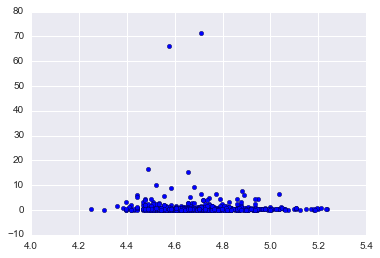

In [28]:
error_df['Log_Runtime'] = full_dropped.ix[error_df.index, 'Log_Runtime']
plt.scatter(error_df.Log_Runtime, error_df.Percent_Error) # Ok who the fuck fucked up

# this is not a lot of evidence, but it does hint that my model is not so great at predicting low budget movies 
# but who makes those anymore anyway
error_df[error_df.Percent_Error> 10]

We can check that by inspecting how our model did in relation to the budget of the movie.

#### Inspecting Predictions by Budget
----------------------------------------

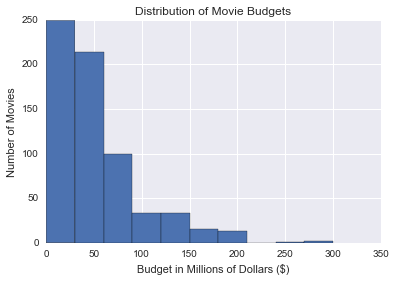

In [29]:
# BUDGET UNITS ARE IN MILLIONS
error_df.X_Budget.hist()
plt.title('Distribution of Movie Budgets')
plt.xlabel('Budget in Millions of Dollars ($)')
plt.ylabel('Number of Movies')

Lets group our films into one of five budget categories:
    - Low Budget (<10Mil)
    - Low-Intermediate Budget (10-50mil)
    - Intermediate Budget (50-100mil)
    - High-Intermediate Budget (100-200 mil)
    - High Budget (>200mil)

In [30]:
# Lets make 5 Groups
bins = [0, 10, 50, 100, 200, 400]

# square brackets [] mean open/inclusive, () means closed
error_df['Budget_Group'] = pd.cut(error_df.X_Budget, bins=bins, right = False, 
                                  labels = ['Low','Low_Intermediate', 'Intermediate','High_Intermediate', 'High'])

error_df.groupby('Budget_Group').Percent_Error.median()

Budget_Group
Low                  0.430
Low_Intermediate     0.455
Intermediate         0.370
High_Intermediate    0.310
High                 0.340
Name: Percent_Error, dtype: float64

Our model seems to get better at predicting as the budget of the movie goes up.

In [33]:
error_df[error_df.Budget_Group == 'High']

# relatively low Percent Errors

,Title,X_Budget,Y_Actual,Y_Pred,Error,Abs_Error,Percent_Error,Log_Runtime,Budget_Group
514,Transformers: Revenge of the Fallen,210.0,836.30,1105.09,-268.78,268.78,0.32,4.969813,High
906,Green Lantern,200.0,219.85,352.09,-132.24,132.24,0.60,4.653960,High
890,Tron Legacy,200.0,400.06,346.51,53.55,53.55,0.13,4.828314,High
1492,Spider-Man 2,200.0,783.77,617.60,166.16,166.16,0.21,4.844187,High
884,The Amazing Spider-Man 2,200.0,708.98,1041.51,-332.53,332.53,0.47,4.955827,High
121,Robin Hood,210.0,321.67,402.82,-81.15,81.15,0.25,4.997212,High
106,Pirates of the Caribbean: At World's End,300.0,963.42,982.22,-18.80,18.80,0.02,5.123964,High
300,The Lone Ranger,275.0,260.50,417.60,-157.10,157.10,0.60,5.003946,High
522,Terminator Salvation,200.0,371.35,571.06,-199.71,199.71,0.54,4.736198,High
1112,The Golden Compass(Anti-Christian),205.0,372.23,394.72,-22.48,22.48,0.06,4.727388,High


#### Inspecting Predictions By Actor Score

In [34]:
error_df['Total_Actor_Score'] = full_dropped.ix[error_df.index, 'Total_Actor_Score']

# divide into bins

act_scr_bins = [0,1, 10,50,100,200, 300, 400]
error_df['Act_Scr_Bins'] = pd.cut(error_df.Total_Actor_Score, bins = act_scr_bins, right = False,
                                 labels = ['0', '1-10', '10-50', '50-100','100-200', '200-300', '300+'])


While I don't see much of a relationship... My model does seem to improve a little as actor scores increase.

Act_Scr_Bins
0          0.430
1-10       0.330
10-50      0.400
50-100     0.370
100-200    0.425
200-300    0.490
300+       0.760
Name: Percent_Error, dtype: float64

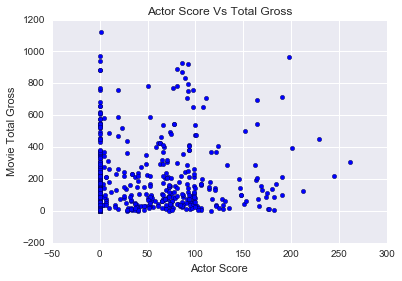

In [37]:
plt.scatter(error_df.Total_Actor_Score, error_df.Y_Actual)
plt.title('Actor Score Vs Total Gross')
plt.xlabel('Actor Score')
plt.ylabel('Movie Total Gross')
error_df.groupby('Act_Scr_Bins').Percent_Error.median()

So who are my good actors?

In [38]:
best_actrs_df = full_dropped[(full_dropped.Total_Actor_Score > 100) & ((full_dropped.Total_Gross/1000000).round() >600)]

# Actors ordered by number of top grossing movies (with an Actor Score > 100) that they appear in
pd.Series(best_actrs_df.Actors.sum()).value_counts()[:20] 

Ashley Greene        7
Kristen Stewart      7
Peter Facinelli      7
Kellan Lutz          7
Robert Pattinson     7
Taylor Lautner       7
Jackson Rathbone     7
Billy Burke          7
Elizabeth Reaser     6
Nikki Reed           5
Johnny Depp          4
Michael Sheen        4
Natalie Portman      4
Naomie Harris        4
Anthony Daniels      3
Jack Davenport       3
Stellan Skarsgard    3
Ian McDiarmid        3
Michael Caine        3
Dakota Fanning       3
dtype: int64

Lets broaden the serach to include ALL films that grossed more than 600 mil (including our outliers)

In [39]:
best_films = full[full.Total_Gross>600000000]
print best_films.shape # 131 films
all_best_actrs = pd.Series(best_films.Actors.sum()).value_counts()
all_best_actrs[all_best_actrs>3][:21]

(131, 44)


Ian McKellen          9
Rupert Grint          8
Emma Watson           8
Robert Pattinson      8
Orlando Bloom         8
Daniel Radcliffe      8
Billy Burke           7
Gary Oldman           7
Ashley Greene         7
Taylor Lautner        7
Peter Facinelli       7
Kristen Stewart       7
Kellan Lutz           7
Jackson Rathbone      7
Tyrese Gibson         6
Elizabeth Reaser      6
Eddie Murphy          6
Scarlett Johansson    6
Antonio Banderas      6
Cameron Diaz          6
Mike Myers            6
dtype: int64

Most of these actors are heavy hitters in famous series/franchises aka Ian Mckellen is in Lord of the Rings and X-Men, Rupert Grint and Emma Watson are in Harry Potter, A lot of people from twilight. This doesn't negate the idea that these are the guys/gals you want hire however. It's more a question of did these actors make their franchises great - or did the franchise make the actor great?


#### Inspecting Predictions By Director Score

In [40]:
error_df['Director_Score'] = full_dropped.ix[error_df.index, 'Director_Score']

error_df.Director_Score.value_counts()
dir_bins = [0,5,10,15,20,30]
error_df['Dir_Bins'] = pd.cut(error_df.Director_Score, dir_bins, right = True,
                             labels = ['0-5','5-10','10-15','15-20','>20'])
error_df.groupby('Dir_Bins').Percent_Error.mean()
# Slight Increase as dir score goes up

Dir_Bins
0-5      0.568571
5-10     0.580000
10-15    0.417000
15-20    0.330588
>20      0.451053
Name: Percent_Error, dtype: float64

# Examining Where My Model Shined

I'm gonna look at the movies where my models prediction was within 10% of the actual gross

### Actors

In [41]:
accurate = full_dropped[full_dropped.Title.isin(error_df[error_df.Percent_Error<10].Title)]

predictable_actrs = pd.Series(accurate.Actors.sum()).value_counts()
predictable_actrs[predictable_actrs > 5][:21]


# These are predictable actors... They appear in movies that my model is good at predicting. 
# However this doesn't say whether or not they are predictably succesfull or unsuccesfull, 
# just that they are predictable

Jamie Foxx         12
Nicolas Cage       12
Stanley Tucci      11
Hugh Jackman       10
Nicole Kidman      10
Brad Pitt          10
Dwayne Johnson     10
Woody Harrelson     9
Tom Hanks           9
Cameron Diaz        9
Eddie Murphy        9
Vince Vaughn        9
Kristen Wiig        9
Jonah Hill          9
Steve Carell        9
Matt Damon          9
Aaron Eckhart       8
Paul Giamatti       8
Colin Farrell       8
John Travolta       8
Johnny Depp         8
dtype: int64

### Release Month

In [42]:
# Summer and Fall... nothign much here except studios like to release during winter holidays
accurate.Release_Month.value_counts()

12    81
11    74
7     68
8     60
6     60
10    56
5     53
3     53
4     48
2     45
9     35
1     21
Name: Release_Month, dtype: int64

### Genre

Comedies, Horror, Action and Drama are most predictable...but predictably what...

In [43]:
accurate.ix[:,25:].sum().sort_values(ascending=False)

Comedy                   195.0
Drama                    136.0
Horror_Thriller          134.0
Action                   130.0
Adventure                 56.0
Romantic                  51.0
Animation                 46.0
Scifi                     46.0
Crime                     36.0
Family_Kids               30.0
Fantasy                   26.0
Sport                     20.0
Music_Musical             16.0
Western                    8.0
War                        7.0
Foreign                    6.0
Biography_Documentary      2.0
Other                      1.0
Disaster                   0.0
dtype: float64

Comedies are predictably worse than median gross

In [44]:
print full_dropped.Total_Gross.median()
accurate.groupby('Comedy').Total_Gross.median()

98410061.0


Comedy
0.0    108539911.0
1.0     80916492.0
Name: Total_Gross, dtype: float64

Horrors are predictably worse than median gross

In [45]:
print full_dropped.Total_Gross.median()
accurate.groupby('Horror_Thriller').Total_Gross.median()

98410061.0


Horror_Thriller
0.0    102400566.5
1.0     81649409.5
Name: Total_Gross, dtype: float64

Action is predictably better than median gross

In [46]:
print full_dropped.Total_Gross.median()
accurate.groupby('Action').Total_Gross.median()

98410061.0


Action
0.0     87262155.0
1.0    168783471.0
Name: Total_Gross, dtype: float64

Drama is Predictably Worse

In [47]:
print full_dropped.Total_Gross.median()
accurate.groupby('Drama').Total_Gross.median()

98410061.0


Drama
0.0    108218336.0
1.0     52760129.5
Name: Total_Gross, dtype: float64